In [26]:
# On Google Colab, you may need to restart the runtime after this
!pip install requests bs4 transformers torch torchvision umap-learn matplotlib dill ortools 
!pip install --upgrade plotly

  Using cached transformers-4.6.1-py3-none-any.whl (2.2 MB)
     |████████████████████████████████| 804.1 MB 2.7 kB/s 
     |████████████████████████████████| 17.4 MB 113 kB/s 
Processing /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4/umap_learn-0.5.1-cp37-none-any.whl
     |████████████████████████████████| 81 kB 11.8 MB/s 
  Using cached ortools-9.0.9048-cp37-cp37m-manylinux1_x86_64.whl (14.4 MB)
     |████████████████████████████████| 115 kB 54.2 MB/s 
  Using cached tokenizers-0.10.2-cp37-cp37m-manylinux2010_x86_64.whl (3.3 MB)
  Using cached huggingface_hub-0.0.8-py3-none-any.whl (34 kB)
     |████████████████████████████████| 720 kB 72.3 MB/s 
  Using cached sacremoses-0.0.45-py3-none-any.whl (895 kB)
     |████████████████████████████████| 40 kB 6.8 MB/s 
     |████████████████████████████████| 27.4 MB 91 kB/s 
Processing /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e/pynndescent-0.5.2-cp37-none-any.whl
  

  Using cached plotly-4.14.3-py2.py3-none-any.whl (13.2 MB)
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=b146c4a21d583af7a78cf29104fd97da31944500f0b926029dce44b968b51482
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [27]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0  33990      0 --:--:-- --:--:-- --:--:-- 33663


python version: 3.7.10
remove current miniconda
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added omnia to channels
added conda-forge to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda
                         /usr/local



In [28]:
!pip install --pre deepchem
import deepchem
deepchem.__version__


  Using cached deepchem-2.6.0.dev20210520034915-py3-none-any.whl (564 kB)


'2.6.0.dev'

In [29]:
%env PYTHONPATH=


env: PYTHONPATH=


In [30]:
%%bash
# Install UMAP/hdbscan (recommend to do this before miniconda)
pip install --quiet umap-learn hdbscan

# Install miniconda
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.9.2-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget -q https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX > /dev/null

# Install rdkit (should only be installed via conda)
conda install -y --quiet -c conda-forge rdkit=2020.09.2 > /dev/null


In [65]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


In [66]:
import os
import time
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

import hdbscan


In [67]:

def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list: List[str]):
    """ Computes ecfp descriptors """
    
    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)
    
    return None

In [68]:
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


In [69]:
def plot_global_embeddings_with_clusters(df: pd.DataFrame,
                          x_col: str,
                          y_col: str,
                          cluster_col: str,
                          title: str = "",
                          x_lim = None,
                          y_lim = None):
    """ Plots data colored by soft HDBSCAN clusters
    
    If the cluster of a compund is not specified (cluster < 0), it will be
    plotted gray, otherwise it will be colored by the cluster value.
    """
    clustered = df[cluster_col].values >= 0
    
    plt.figure(figsize=(10,8))
    ax=sns.scatterplot(data=df.iloc[~clustered],
                    x=x_col,
                    y=y_col,
                    color=(0.5, 0.5, 0.5),
                    s=10,
                    alpha=0.1)
    sns.scatterplot(data=df.iloc[clustered],
                    x=x_col,
                    y=y_col,
                    hue=cluster_col,
                    alpha=0.5,
                    palette="nipy_spectral",
                    ax=ax)
    if x_lim:
      ax.set_xlim(x_lim)
    if y_lim:
      ax.set_ylim(y_lim)

    sm = plt.cm.ScalarMappable(cmap="nipy_spectral")
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm, label="Global Cluster")
  
    plt.title(title)
    plt.show()


In [88]:
# Read in data from MoleculeNet
bbbp = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv")

# Clean up columnn names so they are easier to interpret
bbbp = bbbp[["smiles", "p_np", "name"]].reset_index(drop=True).rename({"p_np": "permeable"}, axis=1)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()

# conv3ert to str list
smiles = bbbp['smiles'].astype(str).tolist()




# Compute transformer embeddings (using BPE tokenization)

In [89]:
print (len(smiles))

2050


In [90]:
# compute transformer embeddings

from transformers import AutoTokenizer, AutoModel
import torch


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def gen_embeddings (model, tokenizer):
    #Tokenize sentences
    encoded_input = tokenizer(smiles, padding=True, truncation=True, max_length=128, return_tensors='pt')

    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    #Perform pooling. In this case, mean pooling
    return mean_pooling(model_output, encoded_input['attention_mask'])

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_396_250")
model = AutoModel.from_pretrained("seyonec/PubChem10M_SMILES_BPE_396_250")

tokenizer_2 = AutoTokenizer.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k")
model_2 = AutoModel.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k")


bpe_sentence_embeddings = gen_embeddings(model, tokenizer)

st_sentence_embeddings = gen_embeddings(model_2, tokenizer_2)

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights

# Compute ECFP descriptors

In [49]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


In [75]:
%%time
#embed with umap
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(bpe_sentence_embeddings)
bbbp["BPE_UMAP_0"], bbbp["BPE_UMAP_1"] = X_umap[:,0], X_umap[:,1]


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CPU times: user 55.9 s, sys: 254 ms, total: 56.1 s
Wall time: 33.8 s


In [77]:
%%time
#embed with umap
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(st_sentence_embeddings)
bbbp["st_UMAP_0"], bbbp["st_UMAP_1"] = X_umap[:,0], X_umap[:,1]


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CPU times: user 57.8 s, sys: 232 ms, total: 58 s
Wall time: 33.9 s


In [94]:
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Only keep those that sucessfully featurized
bbbp = bbbp.iloc[keep_idx]


In [83]:
ecfp_umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
ecfp_X_umap = umap_model.fit_transform(ecfp_descriptors)
bbbp["ecfp_UMAP_0"], bbbp["ecfp_UMAP_1"] = ecfp_X_umap[:,0], ecfp_X_umap[:,1]


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


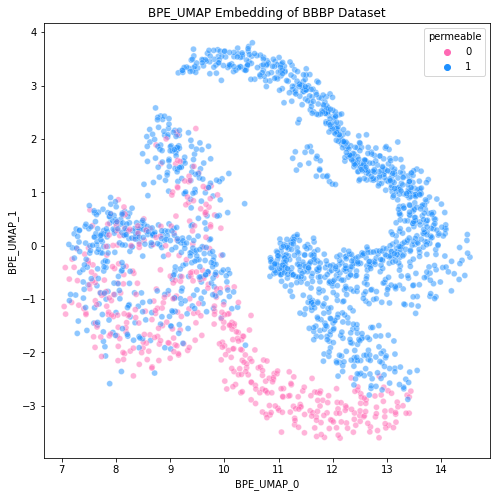

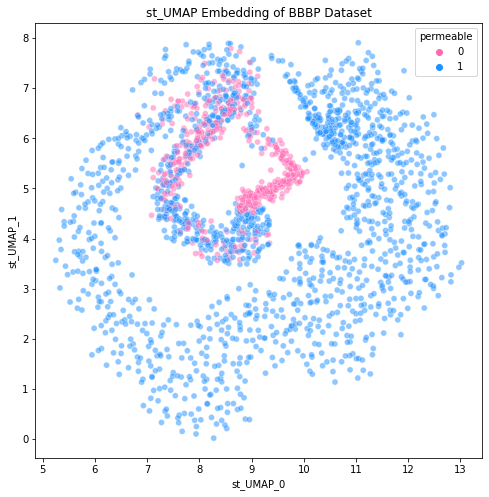

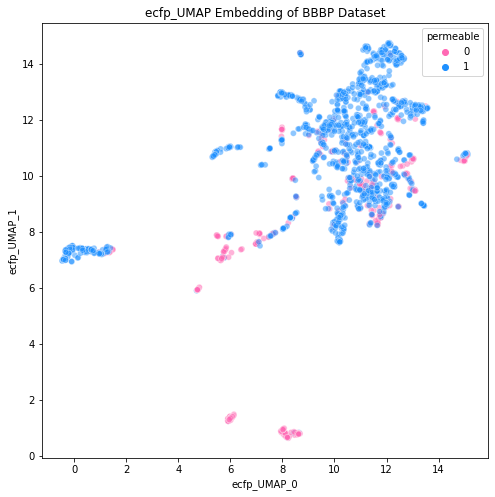

In [85]:
palette = sns.color_palette(["hotpink", "dodgerblue"])
for method in ["BPE_UMAP", "st_UMAP", "ecfp_UMAP"]:
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=bbbp,
                    x=f"{method}_0",
                    y=f"{method}_1",
                    hue="permeable",
                    alpha=0.5,
                    palette=palette)
    plt.title(f"{method} Embedding of BBBP Dataset")
    plt.show()


# modify to try with n_neighbours = 100, same other params

In [91]:
%%time
#embed with umap
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 100,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(bpe_sentence_embeddings)
bbbp["bpe_UMAP_0"], bbbp["bpe_UMAP_1"] = X_umap[:,0], X_umap[:,1]


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CPU times: user 3min 16s, sys: 307 ms, total: 3min 16s
Wall time: 1min 45s


In [92]:
%%time
#embed with umap
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 100,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(st_sentence_embeddings)
bbbp["st_UMAP_0"], bbbp["st_UMAP_1"] = X_umap[:,0], X_umap[:,1]


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CPU times: user 3min 13s, sys: 268 ms, total: 3min 13s
Wall time: 1min 43s


In [95]:
ecfp_umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 100,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
ecfp_X_umap = umap_model.fit_transform(ecfp_descriptors)
bbbp["ecfp_UMAP_0"], bbbp["ecfp_UMAP_1"] = ecfp_X_umap[:,0], ecfp_X_umap[:,1]


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


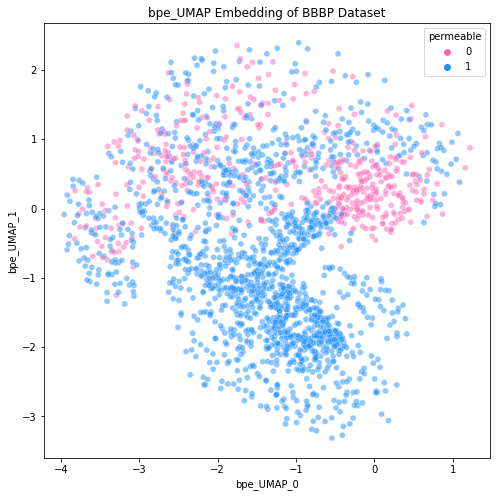

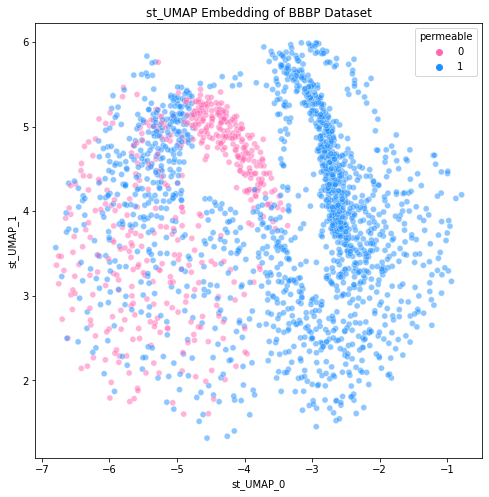

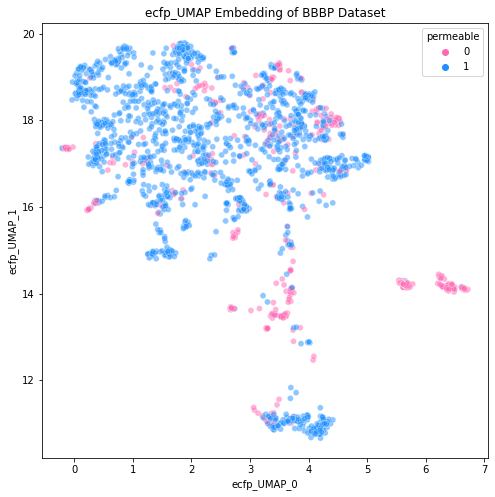

In [96]:
palette = sns.color_palette(["hotpink", "dodgerblue"])
for method in ["bpe_UMAP", "st_UMAP", "ecfp_UMAP"]:
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=bbbp,
                    x=f"{method}_0",
                    y=f"{method}_1",
                    hue="permeable",
                    alpha=0.5,
                    palette=palette)
    plt.title(f"{method} Embedding of BBBP Dataset")
    plt.show()
